<a href="https://colab.research.google.com/github/jeydion/springboard/blob/master/Springboard_Project_Relax_Takehome_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import timedelta
from datetime import datetime
from pandas import Grouper

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [36]:
users_url = 'https://raw.githubusercontent.com/jeydion/springboard/master/takehome_users.csv'
users_df = pd.read_csv(users_url, encoding='latin1')
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [37]:
time_url = 'https://raw.githubusercontent.com/jeydion/springboard/master/takehome_user_engagement.csv'
time_df = pd.read_csv(time_url, encoding='latin1', parse_dates=['time_stamp'])
time_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


## EDA

With both files loaded, analysis can begin. First the amount of visits per user need to be aggregated as well as their times. From there a new column can be made labelled "adopted user". This column will be the boolean value if a user has visited on three seperate days in a week.

In [38]:
time_df.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [39]:
# Group by time_stamp
df3 = time_df.groupby([Grouper(key='time_stamp', freq='W'), 'user_id']).agg({'visited': np.sum})
df4 = df3.reset_index()
df4.head(10)

,time_stamp,user_id,visited
0,2012-06-03,563,1
1,2012-06-03,1693,1
2,2012-06-03,1995,1
3,2012-06-03,2120,1
4,2012-06-03,2136,1
5,2012-06-03,2494,1
6,2012-06-03,2568,1
7,2012-06-03,3428,1
8,2012-06-03,3514,1
9,2012-06-03,3721,1


In [40]:
#this helps sort the datetime series
visits_df = time_df.groupby(['user_id', Grouper(key='time_stamp', freq='D')]).agg({'visited': np.sum})
visits_df.reset_index()
visits_df.head()

visited
user_id time_stamp         
1       2014-04-22        1
2       2013-11-15        1
        2013-11-29        1
        2013-12-09        1
        2013-12-25        1

In [41]:
# Make list of first time stamp
visits_df= df4[['time_stamp','user_id']]
df6 = visits_df.groupby(['user_id']).first().reset_index()
first = list(df6.loc[:,'time_stamp'])

# Make list of last day user visited
df7 = visits_df.groupby(['user_id']).last().reset_index()
last = list(df7.loc[:,'time_stamp'])

# Make list of all users that visited
df8 = visits_df.groupby(['user_id']).count().reset_index()
usr_list = list(df8.loc[:, 'user_id'])
df8.head()

,user_id,time_stamp
0,1,1
1,2,11
2,3,1
3,4,1
4,5,1


In [0]:

visited = []
for n in range(len(usr_list)):
    #this meets the condition for at least 7 days and 
    if ((last[n]-first[n]) >= timedelta(7)) and (df8.loc[n, 'time_stamp'] == 3):
        visited_usr = df8.loc[n, 'user_id']
        visited.append(str(visited_usr))

In [43]:
len(visited)

271

In [44]:
time_df['adopted_user'] = time_df['user_id'].isin(visited).astype(int)
time_df.head()

,time_stamp,user_id,visited,adopted_user
0,2014-04-22 03:53:30,1,1,0
1,2013-11-15 03:45:04,2,1,0
2,2013-11-29 03:45:04,2,1,0
3,2013-12-09 03:45:04,2,1,0
4,2013-12-25 03:45:04,2,1,0


In [45]:
time_df.adopted_user.sum()

974

We know there are 974 adopted users. Now we need to do further analytical research to identify features. Both datasets will be merged. 

In [46]:
users_df=users_df.rename(columns = {'object_id':'user_id'})
print(users_df.head())
print(users_df.dtypes)
print(users_df.isnull().sum())

   user_id        creation_time  ... org_id invited_by_user_id
0        1  2014-04-22 03:53:30  ...     11            10803.0
1        2  2013-11-15 03:45:04  ...      1              316.0
2        3  2013-03-19 23:14:52  ...     94             1525.0
3        4  2013-05-21 08:09:28  ...      1             5151.0
4        5  2013-01-17 10:14:20  ...    193             5240.0

[5 rows x 10 columns]
user_id                         int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object
user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    

In [47]:
# Need to change null values; float values will be the median value

for col in users_df.select_dtypes(include=np.number):
    users_df[col] = users_df[col].fillna(users_df[col].median())
    
users_df.isnull().sum()

user_id                       0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
dtype: int64

In [48]:
df = pd.merge(users_df, time_df, on='user_id')
df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,1,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-15 03:45:04,1,0
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-29 03:45:04,1,0
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-09 03:45:04,1,0
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-25 03:45:04,1,0


In [49]:
df.dtypes

user_id                                int64
creation_time                         object
name                                  object
email                                 object
creation_source                       object
last_session_creation_time           float64
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
time_stamp                    datetime64[ns]
visited                                int64
adopted_user                           int64
dtype: object

In [0]:
# Convert last_session_creation_time to DateTime
df['last_session_creation_time'] = pd.to_datetime(df['last_session_creation_time'],unit='s')

The following cells are work in progress. I kept getting an error when trying to analyze the time columns. Upon consulting other Springboard students and Stack Overflow, I found a solution that helps further the analysis. <br/>
I also dropped the user_id, name, email columns since personal information won't help the analysis. 

In [0]:
df = df.drop(['name', 'email','user_id'], axis = 1)


In [0]:
df['creation_time'] = pd.to_datetime(df['creation_time'])

In [0]:
df['creation_time']= df['creation_time'].astype(np.int64) / 10**9
df['last_session_creation_time']= df['last_session_creation_time'].astype(np.int64) / 10**9
df['time_stamp']= df['time_stamp'].astype(np.int64) / 10**9

In [54]:
final_df = pd.concat([df, pd.get_dummies(df['creation_source'], drop_first=True)], axis=1)
final_df = final_df.drop('creation_source', axis=1)
final_df.head()

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,visited,adopted_user,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1.398139e+09,1.398139e+09,1,0,11,10803.0,1.398139e+09,1,0,0,0,0,0
1,1.384487e+09,1.396238e+09,0,0,1,316.0,1.384487e+09,1,0,1,0,0,0
2,1.384487e+09,1.396238e+09,0,0,1,316.0,1.385697e+09,1,0,1,0,0,0
3,1.384487e+09,1.396238e+09,0,0,1,316.0,1.386561e+09,1,0,1,0,0,0
4,1.384487e+09,1.396238e+09,0,0,1,316.0,1.387943e+09,1,0,1,0,0,0


In [0]:
# Split data into train-test sets
train_set, test_set = train_test_split(final_df, test_size=0.2, random_state=42)

Ran into the issue that the train-test sets will be very unbalanced with respect to the adopted_user feature. Will resample to correct this imbalance.

In [56]:
copytrain_df = train_set.copy()
copytrain_df['adopted_user'].value_counts()


0    165558
1       775
Name: adopted_user, dtype: int64

In [0]:
unadopted_df = copytrain_df[copytrain_df['adopted_user'] == 0]
adopted_df = copytrain_df[copytrain_df['adopted_user'] == 1]

In [0]:
adopted_resampled_df = resample(adopted_df, 
                                 replace=True,     
                                 n_samples=165558,
                                 random_state=42)

In [0]:
final_resampled_df = pd.concat([unadopted_df, adopted_resampled_df])

In [60]:
final_resampled_df['adopted_user'].value_counts()

1    165558
0    165558
Name: adopted_user, dtype: int64

In [0]:
# Seperated features from target

#creating predictors and target variables for the train set
X_train = final_resampled_df.drop('adopted_user', axis=1)
y_train = final_resampled_df['adopted_user']

##creating predictors and target variables for the test set
copytest_df = test_set.copy()
X_test = copytest_df.drop('adopted_user', axis=1)
y_test = copytest_df['adopted_user']


In [0]:
def train_test_model(X_train, X_test, y_train, y_test, model):
    '''Function will split the data'''
    # Create train and test sets
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
    # Convert DataFrames to NumPy Arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
        
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Predict the labels of the test set: y_pred
    y_pred = model.predict(X_test)
    
    # Prediction for ROC curve 
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show();
    
    
    print(classification_report(y_test, y_pred))

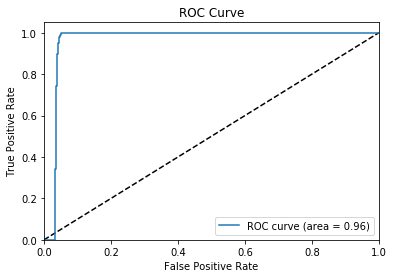

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     41385
           1       0.07      1.00      0.13       199

    accuracy                           0.94     41584
   macro avg       0.54      0.97      0.55     41584
weighted avg       1.00      0.94      0.96     41584



In [73]:
logreg = LogisticRegression(n_jobs=1, solver='lbfgs', max_iter=1000)
c_space = np.logspace(-10, 8, 20)
logreg_param_grid = {'C': c_space}

train_test_model(X_train,X_test,y_train,y_test,logreg,logreg_param_grid)

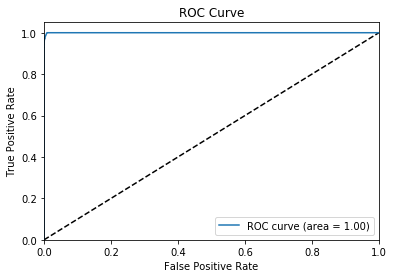

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41385
           1       0.99      0.88      0.93       199

    accuracy                           1.00     41584
   macro avg       1.00      0.94      0.97     41584
weighted avg       1.00      1.00      1.00     41584



In [77]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1)
forest_param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": range(10,500,20),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "oob_score": True}
train_test_model(X_train, X_test, y_train, y_test, forest, forest_param_grid)

Though very close, the Random Forests classifier has a near perfect accuracy score as well as ROC curve. When the model is fit, the list of feature importance is printed below.

In [75]:
best_model = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=None, max_features=3, min_samples_split=250, n_estimators=5)
best_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=250,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [76]:
feature_importances = pd.DataFrame(best_model.feature_importances_, 
             index = X_train.columns, columns = ['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
last_session_creation_time,0.426900
creation_time,0.357825
time_stamp,0.121554
org_id,0.043210
invited_by_user_id,0.029904
opted_in_to_mailing_list,0.005295
enabled_for_marketing_drip,0.004827
SIGNUP,0.004131
SIGNUP_GOOGLE_AUTH,0.003285
PERSONAL_PROJECTS,0.001723


The most important features are last_session_creation_time, creation_time and time_stamp. 